In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import tensorflow as tf
import os
import glob
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm 

from model.model import CalliGenerator

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
image_dir = 'datasets-with-paper/images/train'
components_path = 'datasets-with-paper/components/hanzi2components.txt'
special_ids = None

hanzi2components = {}
with open(components_path, encoding='utf-8') as f:
    for line in f.readlines():
        hanzi, components = line.strip().split('\t')
        hanzi2components[hanzi] = components.split(';')[0]

image_paths = []
if special_ids != None:
    special_ids = str(special_ids).split(',')
    for path in os.listdir(image_dir):
        if (path.endswith('.jpg') or path.endswith('.png')) and ((path.split('_')[0] in special_ids)):
            image_paths.append(path)
else:
    image_paths = [path for path in os.listdir(image_dir) if path.endswith('.jpg') or path.endswith('.png')]

In [4]:
model = CalliGenerator()
discard = model([tf.zeros([1, 28]), tf.zeros([1, 256, 256, 1]), tf.zeros([1, 7])])
model.load_weights('CalliGAN_generator.h5')

In [5]:
def load_all(path):
    image = tf.keras.utils.load_img(os.path.join(image_dir, path))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image[image<50] = 0.
    image[image>50] = 255.

    source = image[:, :256, 0:1]
    target = image[:, 256:, 0:1]
    source = (source/127.5)-1. # tanh activation functoion
    target = (target/127.5)-1.

    # components
    hanzi = path.split('.')[0]
    hanzi = hanzi.split('_')[1]
    components = [int(value) for value in hanzi2components[hanzi].split(',')]
    components = tf.keras.preprocessing.sequence.pad_sequences([components], maxlen=28, padding='post')[0]
    components = components.astype(np.float32)

    # one-hot encode category
    font_index = int(path.split('_')[0])
    category = tf.keras.utils.to_categorical(font_index-1, num_classes=7)
    
    return (components, source, category), target

In [6]:
image_size = 256
row = 5
column = 5

In [7]:
components = []
images = []
categories = []
labels = []

for path in np.random.choice(image_paths, size=row*column):
    (co, s, c), t = load_all(path)
    components.append(co)
    images.append(s)
    categories.append(c)
    labels.append(t)
components = np.asarray(components)
images = np.asarray(images)
categories = np.asarray(categories)
labels = np.asarray(labels)

In [8]:
comparer = []

generated_images = model.predict((components, images, categories))
for index, generated_image in enumerate(generated_images):
    canvas = Image.new('RGB', (3*image_size, image_size))
    
    # source
    source_image = images[index]
    source_image = ((source_image+1.)*127.5).astype(np.uint8)
    source_image = cv.cvtColor(source_image, cv.COLOR_GRAY2RGB)
    canvas.paste(Image.fromarray(source_image), (0, 0))
    
    # target
    target_image = labels[index]
    restored_target_image = ((target_image+1.)*127.5).astype(np.uint8)
    restored_target_image = cv.cvtColor(restored_target_image, cv.COLOR_GRAY2RGB)
    canvas.paste(Image.fromarray(restored_target_image), (image_size, 0))

    # prediction
    restored_generated_image = ((generated_image+1.)*127.5).astype(np.uint8)
    restored_generated_image = cv.cvtColor(restored_generated_image, cv.COLOR_GRAY2RGB)
    canvas.paste(Image.fromarray(restored_generated_image), (image_size*2, 0))

    comparer.append(canvas)

1/1 [==============================] - 3s 3s/step


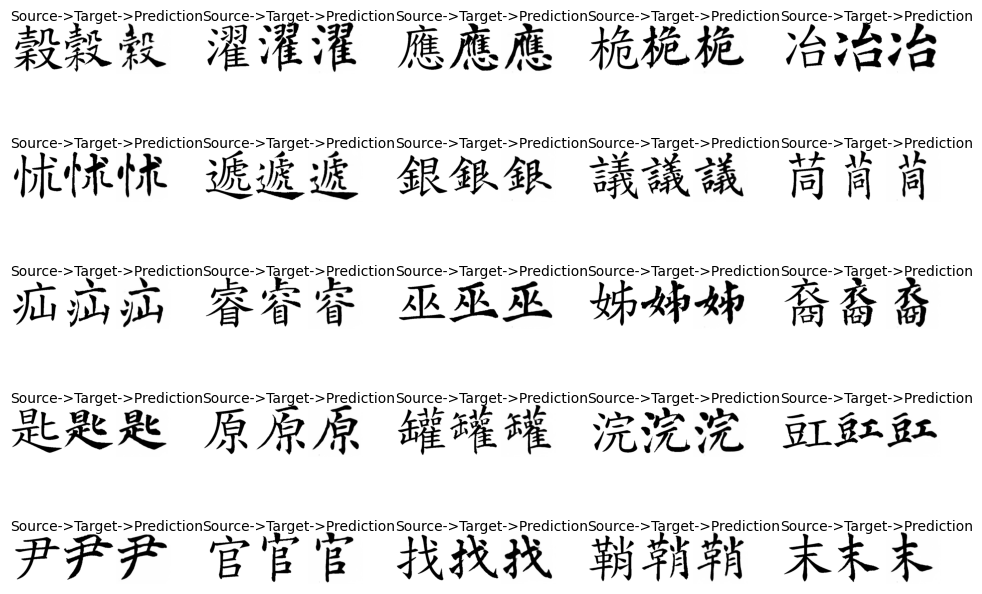

In [10]:
figure, axis = plt.subplots(row, column)
for index, image in enumerate(comparer):
    axis[index//row, index%column].text(0, 0, 'Source->Target->Prediction')
    axis[index//row, index%column].imshow(image)
    axis[index//row, index%column].set_axis_off()